{0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 1, 29: 1, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 1, 41: 1, 42: 1, 43: 1, 44: 0, 45: 0, 46: 0, 47: 1, 48: 1, 49: 2, 50: 2, 51: 0, 52: 0, 53: 0, 54: 0, 55: 1, 56: 1, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 1, 67: 1, 68: 1, 69: 1, 70: 2, 71: 2, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 1, 86: 1, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 1, 97: 1, 98: 0, 99: 0, 100: 0, 101: 0, 102: 1, 103: 1, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 1, 110: 1, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 1, 123: 1, 124: 0, 125: 0, 126: 1, 127: 1, 128: 0, 129: 0, 130: 1, 131: 1, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 

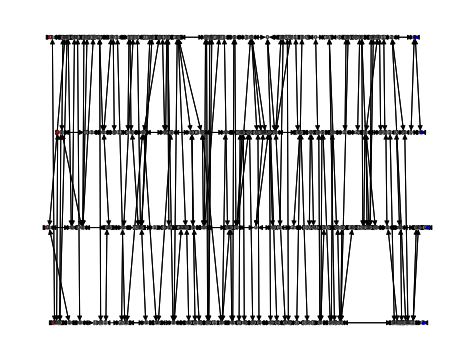

In [4]:
from Partition import *
from Fusion import *
from Graph_State import *

NQubit = 4
Depth = 200
MaxDegree = 3

def to_undirected(gs):
    undirected_graph = nx.Graph()
    for nnode in gs.nodes():
        undirected_graph.add_node(nnode)
        undirected_graph.nodes[nnode]['layer'] = gs.nodes[nnode]['layer']
    for edge in gs.edges():
        if edge not in undirected_graph.edges():
            undirected_graph.add_edge(edge[0], edge[1])
    return undirected_graph



def main():
    gs, input_nodes, colors = generate_graph_state(NQubit, Depth)
    gs = partition(gs, input_nodes)
    undirected_graph = to_undirected(gs)
    fgraph, added_nodes = fusion_graph(undirected_graph, MaxDegree)
    labels = nx.get_node_attributes(gs, 'layer')
    node_pos = nx.get_node_attributes(gs, 'pos')
    nx.draw(gs, pos = node_pos, node_color = colors, node_size = 10, labels = labels,  font_size=5)
    print(labels)
    return

if __name__ == '__main__':
    main()